# Kinematic car sensor fusion example
RMM, 24 Feb 2022

In this example we work through estimation of the state of a car changing
lanes with two different sensors available: one with good longitudinal accuracy
and the other with good lateral accuracy.

All calculations are done in discrete time, using both the form of the Kalman
filter in Theorem 7.2 and the predictor corrector form.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
import control.flatsys as fs

# Define line styles
ebarstyle = {'elinewidth': 0.5, 'capsize': 2}
xdstyle = {'color': 'k', 'linestyle': '--', 'linewidth': 0.5, 
           'marker': '+', 'markersize': 4}

## System definition

### Continuous time model

In [2]:
# Vehicle steering dynamics
#
# System state: x, y, theta
# System input: v, phi
# System output: x, y
# System parameters: wheelbase, maxsteer
#
from vehicle import vehicle, plot_lanechange
print(vehicle)

Object: vehicle
Inputs (2): v, delta, 
Outputs (3): x, y, theta, 
States (3): x, y, theta, 


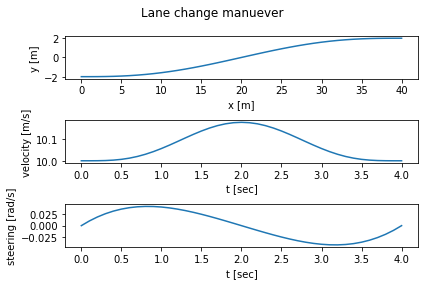

In [3]:
# Generate a trajectory for the vehicle
# Define the endpoints of the trajectory
x0 = [0., -2., 0.]; u0 = [10., 0.]
xf = [40., 2., 0.]; uf = [10., 0.]
Tf = 4

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle, Tf, x0, u0, xf, uf, basis=fs.PolyFamily(6))

# Create the desired trajectory between the initial and final condition
Ts = 0.1
# Ts = 0.5
T = np.arange(0, Tf + Ts, Ts)
xd, ud = traj.eval(T)

plot_lanechange(T, xd, ud)

### Discrete time system model

For the model that we use for the Kalman filter, we take a simple discretization using the approximation that $\dot x = (x[k+1] - x[k])/T_s$ where $T_s$ is the sampling time.

In [4]:
#
# Create a discrete time, linear model
#

# Linearize about the starting point
linsys = ct.linearize(vehicle, x0, u0)

# Create a discrete time model by hand
Ad = np.eye(linsys.nstates) + linsys.A * Ts
Bd = linsys.B * Ts
discsys = ct.LinearIOSystem(ct.ss(Ad, Bd, np.eye(linsys.nstates), 0, dt=Ts))
print(discsys)

Object: sys[2]
Inputs (2): u[0], u[1], 
Outputs (3): y[0], y[1], y[2], 
States (3): x[0], x[1], x[2], 

A = [[ 1.0000000e+00  0.0000000e+00 -5.0004445e-07]
     [ 0.0000000e+00  1.0000000e+00  1.0000000e+00]
     [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]

B = [[0.1        0.        ]
     [0.         0.        ]
     [0.         0.33333333]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]]

dt = 0.1



### Sensor model

We assume that we have two sensors: one with good longitudinal accuracy and the other with good lateral accuracy.  For each sensor we define the map from the state space to the sensor outputs, the covariance matrix for the measurements, and a white noise signal (now in discrete time).

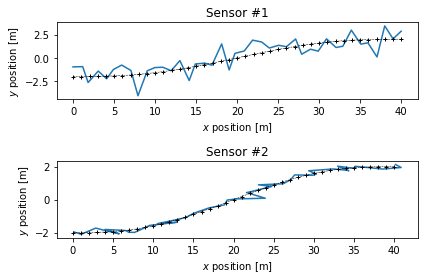

In [5]:
# Sensor #1: longitudinal
C_lon = np.eye(2, discsys.nstates)
Rw_lon = np.diag([0.1 ** 2, 1 ** 2])
W_lon = ct.white_noise(T, Rw_lon, dt=Ts)

# Sensor #2: lateral
C_lat = np.eye(2, discsys.nstates)
Rw_lat = np.diag([1 ** 2, 0.1 ** 2])
W_lat = ct.white_noise(T, Rw_lat, dt=Ts)

# Plot the noisy signals
plt.subplot(2, 1, 1)
Y = xd[0:2] + W_lon
plt.plot(Y[0], Y[1])
plt.plot(xd[0], xd[1], **xdstyle)
plt.xlabel("$x$ position [m]")
plt.ylabel("$y$ position [m]")
plt.title("Sensor #1")
               
plt.subplot(2, 1, 2)
Y = xd[0:2] + W_lat
plt.plot(Y[0], Y[1])
plt.plot(xd[0], xd[1], **xdstyle)
plt.xlabel("$x$ position [m]")
plt.ylabel("$y$ position [m]")
plt.title("Sensor #2")
plt.tight_layout()

## Linear Quadratic Estimator

In [6]:
#
# Create an estimator for the system
#

# Disturbance and initial condition model
Rv = np.diag([0.1, 0.01]) * Ts
# Rv = np.diag([10, 0.1]) * Ts  # No input data
# 
P0 = np.diag([1, 1, 0.1])

# Combine the sensors
C = np.vstack([C_lon, C_lat])
Rw = sp.linalg.block_diag(Rw_lon, Rw_lat)

estim = ct.create_estimator_iosystem(discsys, Rv, Rw, C=C, P0=P0)
print(estim)

Object: sys[3]
Inputs (6): y[0], y[1], y[2], y[3], u[0], u[1], 
Outputs (3): xhat[0], xhat[1], xhat[2], 
States (12): xhat[0], xhat[1], xhat[2], P[0,0], P[0,1], P[0,2], P[1,0], P[1,1], P[1,2], P[2,0], P[2,1], P[2,2], 


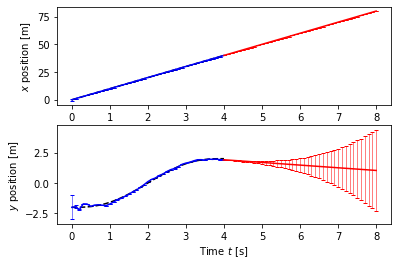

In [7]:
# Compute the inputs to the estimator
Y = np.vstack([xd[0:2] + W_lon, xd[0:2] + W_lat])
U = np.vstack([Y, ud])      # add input to the Kalman filter
# U = np.vstack([Y, ud * 0])  # with no input information
X0 = np.hstack([xd[:, 0], P0.reshape(-1)])

# Run the estimator on the trajectory
estim_resp = ct.input_output_response(estim, T, U, X0)

# Run a prediction to see what happens next
T_predict = np.arange(T[-1], T[-1] + 4 + Ts, Ts)
U_predict = np.outer(U[:, -1], np.ones_like(T_predict))
predict_resp = ct.input_output_response(
    estim, T_predict, U_predict, estim_resp.states[:, -1],
    params={'correct': False})

# Plot the estimated trajectory versus the actual trajectory
plt.subplot(2, 1, 1)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[0], 
    estim_resp.states[estim.find_state('P[0,0]')], fmt='b-', **ebarstyle)
plt.errorbar(
    predict_resp.time, predict_resp.outputs[0], 
    predict_resp.states[estim.find_state('P[0,0]')], fmt='r-', **ebarstyle)
plt.plot(T, xd[0], 'k--')
plt.ylabel("$x$ position [m]")

plt.subplot(2, 1, 2)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[1], 
    estim_resp.states[estim.find_state('P[1,1]')], fmt='b-', **ebarstyle)
plt.errorbar(
    predict_resp.time, predict_resp.outputs[1], 
    predict_resp.states[estim.find_state('P[1,1]')], fmt='r-', **ebarstyle)
# lims = plt.axis(); plt.axis([lims[0], lims[1], -5, 5])
plt.plot(T, xd[1], 'k--');
plt.ylabel("$y$ position [m]")
plt.xlabel("Time $t$ [s]");

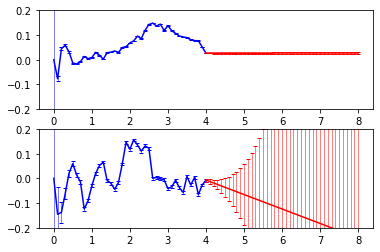

In [8]:
# Plot the estimated errors
plt.subplot(2, 1, 1)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[0] - xd[0], 
    estim_resp.states[estim.find_state('P[0,0]')], fmt='b-', **ebarstyle)
plt.errorbar(
    predict_resp.time, predict_resp.outputs[0] - (xd[0] + xd[0, -1]), 
    predict_resp.states[estim.find_state('P[0,0]')], fmt='r-', **ebarstyle)
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2])
# lims = plt.axis(); plt.axis([lims[0], lims[1], -2, 0.2])

plt.subplot(2, 1, 2)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[1] - xd[1], 
    estim_resp.states[estim.find_state('P[1,1]')], fmt='b-', **ebarstyle)
plt.errorbar(
    predict_resp.time, predict_resp.outputs[1] - xd[1, -1], 
    predict_resp.states[estim.find_state('P[1,1]')], fmt='r-', **ebarstyle)
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2]);

## Things to try
* Remove the input (and update P0)
* Change the sampling rate

## Predictor-corrector form

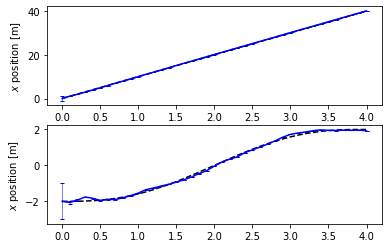

In [11]:
#
# Predictor-corrector calculations
#
# Instead of using create_lqe_iosystem, we can also compute out the estimate
# in a more manual fashion, done here using the predictor-corrector form.

# System matrices
A, B, F = discsys.A, discsys.B, discsys.B

# Create an array to store the results
xhat = np.zeros((discsys.nstates, T.size))
P = np.zeros((discsys.nstates, discsys.nstates, T.size))

# Update the estimates at each time
for i, t in enumerate(T):
    # Prediction step
    if i == 0:
        # Use the initial condition
        xkkm1 = xd[:, 0]
        Pkkm1 = P0
    else:
        xkkm1 = A @ xkk + B @ ud[:, i-1]
        Pkkm1 = A @ Pkk @ A.T + F @ Rv @ F.T
    
    # Correction step
    L = Pkkm1 @ C.T @ np.linalg.inv(Rw + C @ Pkkm1 @ C.T)
    xkk = xkkm1 - L @ (C @ xkkm1 - Y[:, i])
    Pkk = Pkkm1 - L @ C @ Pkkm1

    # Save the state estimate and covariance for later plotting
    # xhat[:, i], P[:, :, i] = xkk, Pkk
    xhat[:, i], P[:, :, i] = xkkm1, Pkkm1  # For comparison to Kalman form
    
plt.subplot(2, 1, 1)
plt.errorbar(T, xhat[0], P[0, 0], fmt='b-', **ebarstyle)
plt.plot(T, xd[0], 'k--')
plt.ylabel("$x$ position [m]")

plt.subplot(2, 1, 2)
plt.errorbar(T, xhat[1], P[1, 1], fmt='b-', **ebarstyle)
plt.plot(T, xd[1], 'k--')
plt.ylabel("$x$ position [m]");

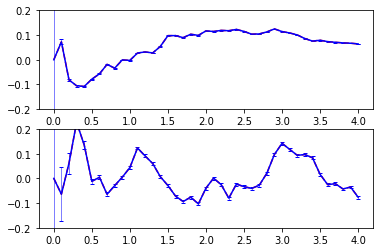

In [12]:
# Plot the estimated errors (and compare to Kalman form)
plt.subplot(2, 1, 1)
plt.errorbar(T, xhat[0] - xd[0], P[0, 0], fmt='b-', **ebarstyle)
plt.plot(estim_resp.time, estim_resp.outputs[0] - xd[0], 'r--')
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2])

plt.subplot(2, 1, 2)
plt.errorbar(T, xhat[1] - xd[1], P[1, 1], fmt='b-', **ebarstyle)
plt.plot(estim_resp.time, estim_resp.outputs[1] - xd[1], 'r--')
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2]);